In [28]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import *
from qiskit import Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# import basic plot tools
from qiskit.visualization import plot_histogram
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [46]:
n = 2  # Maximum length of a input
N = 2**n # Total number of inputs (Domain)
X = Y = Z = range(N) # Domain 

In [69]:
F = { i : np.random.randint(0,N)  for i in X}
G = { i : np.random.randint(0,N) for i in Y}

# F[1] = 5
# G[3] = 5

In [70]:
F

{0: 0, 1: 1, 2: 1, 3: 0}

In [71]:
G

{0: 0, 1: 0, 2: 3, 3: 3}

In [72]:
k = int(np.ceil(np.cbrt(N)))
K = np.random.choice(X, k, replace=False)
K

array([0, 2])

In [74]:
L = [ (i, F[i]) for i in K]
L.sort(key = lambda x: x[1])
L

[(0, 0), (2, 1)]

In [75]:
def search(y):
    """ Check whether there exists x_0 ∈ K so that (x_0, F(x)) ∈ L but x not = x_0.
    
    Since L is sorted by hashes we use binary search on L.    
    """
    low = 0
    high = k-1
    
    while low <= high:
        mid = (low + high)//2
        
        # (x_0, F(x)) ∈ L but x not = x_0
        if L[mid][1] == G[y]:
            return L[mid][0]
        elif (L[mid][1] < G[y]):
            low = mid + 1
        else:
            high = mid - 1
    return -1

def H_mat():
    """ Creates a unitary matrix for H: X -> {0, 1}  
    
    """
    
    size = 2**(n+1) # Since |X| = n, we need n+1 qubits
    U = np.zeros((size, size)) # Initialize the matrix
    
    for i in range(size):
        
        y = i&(2**n-1) # Get x from the first n bits        
        res = search(y) 
        
        if res == -1:
            U[i][i] = 1
        else:
            U[i^(2**n)][i] = 1
    
    print(U)
    qc = QuantumCircuit(n+1)
    qc.unitary(U,range(n+1))
    return qc.to_gate()


In [76]:
def inv_mean(n):
    size = 2**(n)
    A = np.full((size,size), 1/size)
    I = np.identity(size)
    inv_mat = -I + 2*A
    qc = QuantumCircuit(n)
    qc.unitary(inv_mat,range(n))
    return qc.to_gate()

[[0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


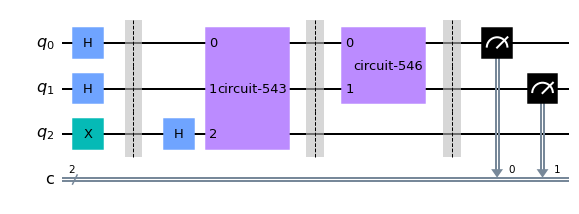

In [77]:
qc = QuantumCircuit(n+1,n)

qc.x(n)
for i in range(n):
    qc.h(i)
    
qc.barrier()

Uf = H_mat()
inv_gate = inv_mean(n)

num_iterations = int((np.pi/4) * np.ceil(np.sqrt((N)/k)))

for i in range(num_iterations):
    # Phase Inversion
    qc.h(n)
    
    qc.append(Uf, range(n+1))
    qc.barrier()

    # Inversion about mean
    qc.append(inv_gate, range(n))
    qc.barrier()


for i in range(n):
    qc.measure(i,i)

qc.draw('mpl')

In [78]:
shots = 1000
simulator = Aer.get_backend('qasm_simulator')
res = execute(qc,backend=simulator, shots=shots).result()
counts = res.get_counts(qc)
counts = { int(i,2): j/shots for i, j in counts.items()}
fig = px.bar(x=counts.keys(), y=counts.values())
fig.show()

In [79]:
y0_s = [int(i,2) for i in res.get_counts(qc).keys()]
claws = []
for y0 in y0_s:
    x0 = search(y0)
    
    if x0 != -1:
        claws.append((x0, y0))

claws

[(0, 0), (0, 1)]